# Model 2 Forecasting Locational Based Marginal Prices (LBMPs)

In [1]:
# Import required packages
import datetime
import os
import zipfile
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import seaborn as sb

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

In [2]:
def ceil_dt(dt, delta):
    # This function calculate the ceiling of a date-time based on given delta
    return datetime.datetime.min + math.ceil((dt - datetime.datetime.min) / delta) * delta

def read_lbmp_data(date_entry='2022-08-06'):
    # reads LBMP data for a given date
    year, month, day = map(int, date_entry.split('-'))
    optimization_date = datetime.date(year, month, day)
    month_folder='../Data/2022_NYISO_LBMP_zonal/'+str(optimization_date.strftime('%Y%m'))+'01realtime_zone_csv'
    file_name=str(optimization_date.strftime('%Y%m%d'))+'realtime_zone.csv'

    # Check if the month folder exists, otherwise unzip the zipped month data folder
    if not os.path.exists(month_folder):
        with zipfile.ZipFile(month_folder+'.zip', 'r') as zip_ref:
            zip_ref.extractall(month_folder)


    # Read data from csv file
    df = pd.read_csv(month_folder+"/"+file_name)
    
    # Keep only 'Time Stamp' and 'LBMP ($/MWHr)' for the NYC zone data and save it as lbmp
    lbmp = df[df['Name'] == 'N.Y.C.'][['Time Stamp','LBMP ($/MWHr)']].reset_index(drop=True)
    
    return lbmp

def read_past_lbmp_data(test_date='2022-08-06',num_train_days=14):
    # reads LBMP data for a given date and given number of training days
    year, month, day = map(int, test_date.split('-'))
    end_date = datetime.date(year, month, day)  # Ending date
    
    start_date = end_date-datetime.timedelta(days=num_train_days)
    
    LBMP=pd.DataFrame()
    while start_date <= end_date:
        LBMP=LBMP.append(read_lbmp_data(start_date.strftime('%Y-%m-%d')))
        start_date +=datetime.timedelta(days=1)
        
    LBMP=LBMP.reset_index(drop=True)
    return LBMP

def calc_avg_lbmp(input_lbmp,delta_t=5):
    # delta_t=int(input('Please enter the resolution of the model as multipicant of 5 minutes (between 5 and 60 minutes):'))
    assert delta_t>=5, 'Time resolution must be at least 5 minutes.'
    assert delta_t<=60, 'Time resolution must be at most 60 minutes.'
    assert delta_t % 5==0, 'Time resolution must be a multipicant of 5 minutes.'
    time_resolution = datetime.timedelta(minutes=delta_t)
    lbmp=input_lbmp
    # For each time stamp, create an 'Agg Time Stamp' which is the ceiling of the time stamp with delta_t
    lbmp['Agg Time Stamp']=lbmp['Time Stamp'].apply(lambda x: ceil_dt(datetime.datetime.strptime(x, '%m/%d/%Y %H:%M:%S'),time_resolution))
    # For each 'Agg Time Stamp' calculate the mean LBMP ($/MWHr)
    lbmp_avg = lbmp.groupby('Agg Time Stamp').mean()
    
    # From now, consider 'Agg Time Stamp' as 'Time Stamp'
    lbmp_avg=lbmp_avg.rename_axis('Time Stamp')
    
    return lbmp_avg['LBMP ($/MWHr)']

In [10]:
def preliminary_LBMP_analysis(test_date='2022-08-06',num_train_days=28,delta_t=60):
    # read LBMP data for the test date and a specific number of train days
    all_LBMP=read_past_lbmp_data(test_date='2022-08-06',num_train_days=num_train_days)
    # Aggregate the LBMP data to get it in a specific time resolution of delta_t
    avg_LBMP=calc_avg_lbmp(all_LBMP,delta_t=delta_t)
    
    # plot the aggregated LBMP
    fig, ax = plt.subplots(figsize=(15,5))
    ax.plot( avg_LBMP,color='b', label='LBMP ($/MWHr)')
    ax.set_xlabel('Time')
    ax.set_ylabel('LBMP ($/MWHr)')
    plt.title('LBMP during train and test set')
    plt.savefig('LBMP_trend.png')
    plt.show()


    # create a dataframe which includes avg_LBMP, date time, day_of_week and Time of day columns
    df_avg_LBMP=pd.DataFrame(avg_LBMP)
    df_avg_LBMP['date time']=pd.to_datetime(df_avg_LBMP.index)
    df_avg_LBMP['day_of_week'] = df_avg_LBMP['date time'].dt.day_name()
    df_avg_LBMP['Time of day']=df_avg_LBMP.index.strftime('%H:%M')
    df_avg_LBMP.to_excel('avg_LBMP.xlsx')
    
    
    # Explore the day of week effect on LBMP
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    plt.figure(figsize=(15, 8))
    sb.boxplot(x="day_of_week", y="LBMP ($/MWHr)", data=df_avg_LBMP)
    plt.title("Boxplots of LBMP ($/MWHr) in different days of week", size=18)
    plt.savefig('LBMP_in_week.png')
    
    # Calculate the mean and standard deviation of LBMP for each time stamp of day 
    grouped = df_avg_LBMP.groupby('Time of day')['LBMP ($/MWHr)'].agg(['mean', 'std'])
    grouped=grouped[1:].append(grouped[:1])

    # Create the bar plot with error bars
    grouped.plot(y='mean', kind='bar', yerr='std',figsize=(15,5))

    # Set the title and axis labels
    plt.title('LBMP mean value with error bars  by time of day')
    plt.xlabel('Time')
    plt.ylabel('LBMP Mean ($/MWH)')
    plt.savefig('LBMP_in_day.png')
    # Show the plot
    plt.show()
    

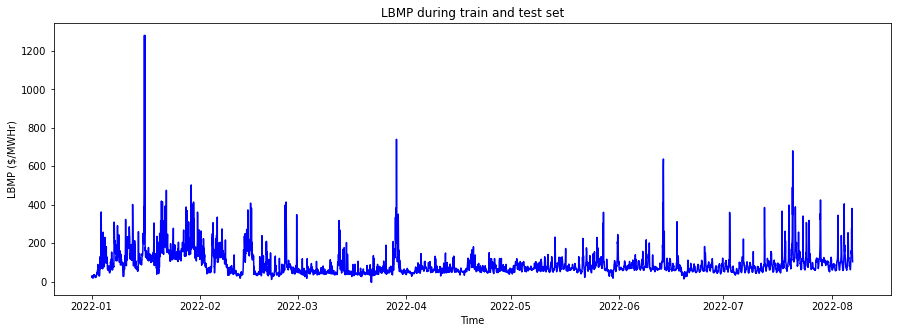

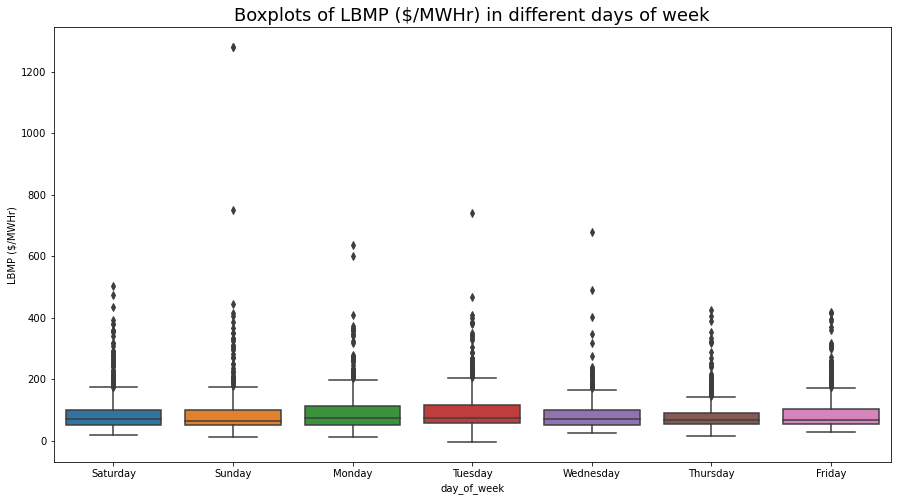

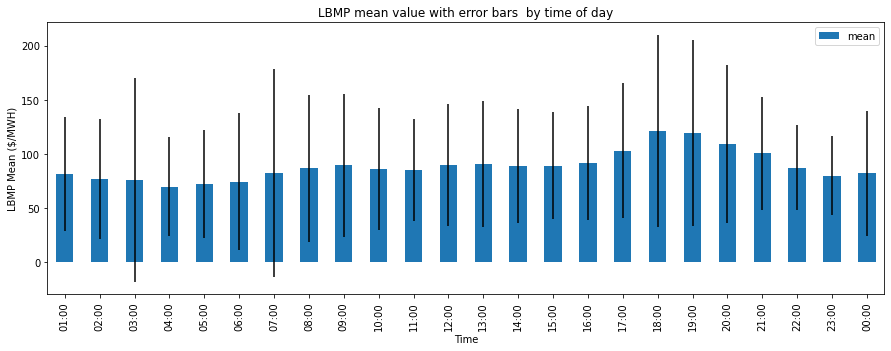

In [11]:
# We consider '2022-08-06' as our test date and 217 days (all prior data) as training data.
preliminary_LBMP_analysis(test_date='2022-08-06',num_train_days=217,delta_t=60)

## Insights
- According to the time series plot, we can partition the dataset into three distinct intervals. The first interval comprises January and February, where the Locational Marginal Prices (LBMPS) exhibit a tendency to be consistently high with a significant degree of variability. The second interval, consisting of March, April, May, and June, is characterized by LBMPS that are generally low but experience sporadic increases. The third interval encompasses July and August and features an upward trend in LBMPS with a substantial degree of variability and frequent spikes. 
- It suggests that it is better to use most recent data (for example the past 3 weeks) to forecast LBMP at '2022-08-06'.


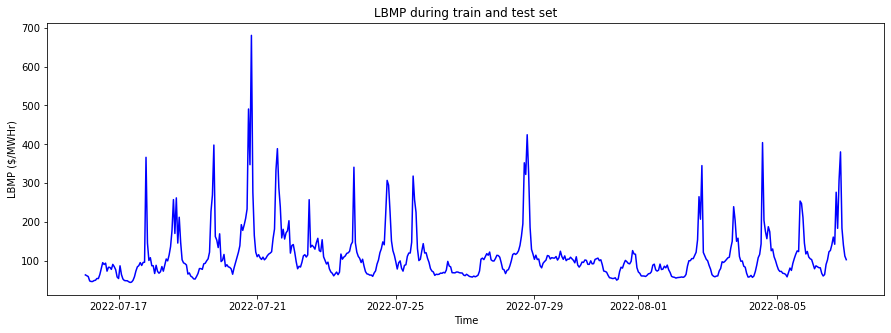

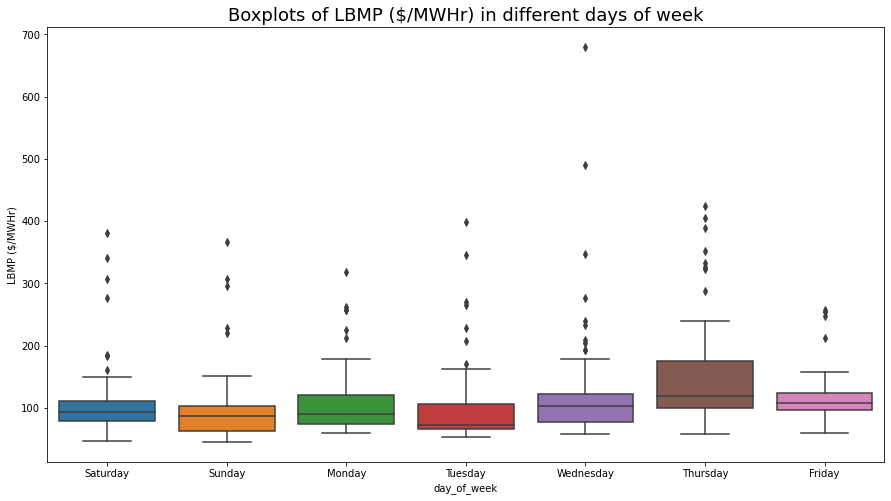

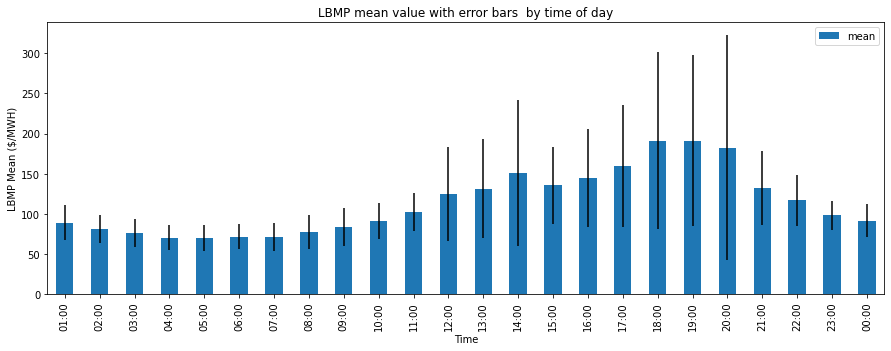

In [12]:
# Let's limit the number of training days to 21 (3 weeks)
preliminary_LBMP_analysis(test_date='2022-08-06',num_train_days=21,delta_t=60)

# Insights:
- According to the analysis, there is no notable difference in LBMP values across various days of the week, except for Thursday which has a slightly higher mean and variance compared to other days. Additionally, the presence of outliers for each day suggests occasional unexpected price surges. Thus, it can be concluded that LBMP values remain consistent throughout the week and are not influenced by the day of the week. However, it is important to keep in mind that this conclusion is based on the specific dataset and analysis performed in this project, and it may not be applicable to other datasets or analyses.

- Based on the analysis of the LBMP mean in different time stamps of the day, it can be observed that the LBMP is lowest during the early morning hours, i.e., between 4:00AM to 8:00AM. In contrast, the LBMP is highest in the evening, i.e., between 6:00PM to 8:00PM. Additionally, it should be noted that the peak times exhibit high variance in the LBMP values.

- It is important to highlight that during the seven-month period from the start of 2022 until August 6, 2022, the significant variance observed in LBMPs obscures the underlying trends and useful information. This is in contrast to the clearer trend evident in the LBMPs during the three-week interval. Specifically, the hourly variance is lower in the three-week dataset, and there is a more distinct contrast in mean LBMPs.

In [6]:
def LSTM_alg(df_avg_LBMP,num_train_days,lookback):
    timeseries = df_avg_LBMP[["LBMP ($/MWHr)"]].values.astype('float32')

    # train-test split for time series
    train_size = int(len(timeseries) * (num_train_days+1-2*lookback/24)/(num_train_days+1))
    test_size = len(timeseries) - train_size
    train, test = timeseries[:train_size], timeseries[train_size:]

    def create_dataset(dataset, lookback):
        """Transform a time series into a prediction dataset

        Args:
            dataset: A numpy array of time series, first dimension is the time steps
            lookback: Size of window for prediction
        """
        X, y = [], []
        for i in range(len(dataset)-lookback):
            feature = dataset[i:i+lookback]
            target = dataset[i+1:i+lookback+1]
            X.append(feature)
            y.append(target)
        return torch.tensor(X), torch.tensor(y)
    
    X_train, y_train = create_dataset(train, lookback=lookback)
    X_test, y_test = create_dataset(test, lookback=lookback)

    class PriceModel(nn.Module):
        def __init__(self):
            super().__init__()
            self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
            self.linear = nn.Linear(50, 1)
        def forward(self, x):
            x, _ = self.lstm(x)
            x = self.linear(x)
            return x

    model = PriceModel()
    optimizer = optim.Adam(model.parameters())
    loss_fn = nn.MSELoss()
    loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

    n_epochs = 1000
    for epoch in range(n_epochs):
        model.train()
        for X_batch, y_batch in loader:
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # Validation
        if epoch % 100 != 0:
            continue
        model.eval()
        with torch.no_grad():
            y_pred = model(X_train)
            train_rmse = np.sqrt(loss_fn(y_pred, y_train))
            y_pred = model(X_test)
            test_rmse = np.sqrt(loss_fn(y_pred, y_test))
        print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))
        
    with torch.no_grad():
        # shift train predictions for plotting
        train_plot = np.ones_like(timeseries) * np.nan
        y_pred = model(X_train)
        y_pred = y_pred[:, -1, :]
        train_plot[lookback:train_size] = model(X_train)[:, -1, :]
        # shift test predictions for plotting
        test_plot = np.ones_like(timeseries) * np.nan
        test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
    # plot
    fig, ax = plt.subplots(figsize=(15, 5))


    # Format the x-axis ticks as dates in the format "Month-Day"
    date_form = DateFormatter("%b-%d")
    ax.xaxis.set_major_formatter(date_form)

    ax.plot(df_avg_LBMP.index,timeseries)

    plt.plot(df_avg_LBMP.index,train_plot, c='r')
    plt.plot(df_avg_LBMP.index,test_plot, c='g')
    plt.xlabel('Time')
    plt.ylabel('LBMP ($/MWH)')
    plt.savefig('tran_test_performance.png')
    plt.show()
    
    y_pred = model(X_test)
    
    LBMP_test=pd.DataFrame(index=df_avg_LBMP.index[-lookback:])
    
    LBMP_test['Actual LBMP']=y_test[:,-1,:].detach().numpy().flatten()
    
    LBMP_test['Predicted LBMP']=y_pred[:,-1,:].detach().numpy().flatten()
    LBMP_test=LBMP_test[-24:]
    LBMP_test.plot(figsize=(15,5))
    # Set the title and axis labels
    plt.title('Comparison of the forecasted and actual LMBPs on 08/06/2022')
    plt.xlabel('Time')
    plt.ylabel('LBMP ($/MWH)')
    plt.savefig('pred_actual.png')
    
    
    
    LBMP_test=LBMP_test.reset_index(drop=True)
    
    
    LBMP_test['Aug 5 LBMP']=df_avg_LBMP['LBMP ($/MWHr)'][-48:-24].reset_index(drop=True)
    LBMP_test.index=df_avg_LBMP.index[-24:]
    LBMP_test.plot(figsize=(15,5))
    # Set the title and axis labels
    plt.title('Comparison of the forecasted and actual LMBPs on 08/06/2022')
    plt.xlabel('Time')
    plt.ylabel('LBMP ($/MWH)')
    plt.savefig('pred_actual_yesterday.png')

    fig, ax = plt.subplots(figsize=(15,5))
    # Calculate the mean and standard deviation for each category
    
    
    
    
    grouped= df_avg_LBMP.groupby('Time of day')['LBMP ($/MWHr)'].agg(['mean', 'std'])

    grouped=grouped[1:].append(grouped[:1])
    # Create the bar plot with error bars
    ax.plot(grouped.index,LBMP_test)
    
    grouped.plot(y='mean',yerr='std', kind='bar',figsize=(15,5),ax=ax)
    lines1, labels1 = ax.get_legend_handles_labels()
    labels_new=LBMP_test.columns.tolist()
    labels_new.append('mean')
    plt.legend(labels_new)
    
    # Set the title and axis labels
    plt.title('LBMP by time of day')
    plt.xlabel('Time')
    plt.ylabel('LBMP ($/MWH)')
    plt.savefig('pred_actual_avg.png')

    # Show the plot
    plt.show()

In [7]:
def main_forecast_alg(test_date='2022-08-06',num_train_days=21,delta_t=60,lookback = 24):
    # read LBMP data for the test date and a specific number of train days
    all_LBMP=read_past_lbmp_data(test_date='2022-08-06',num_train_days=num_train_days)
    # Aggregate the LBMP data to get it in a specific time resolution of delta_t
    avg_LBMP=calc_avg_lbmp(all_LBMP,delta_t=delta_t)
    
    # create a dataframe which includes avg_LBMP, date time, day_of_week and Time of day columns
    df_avg_LBMP=pd.DataFrame(avg_LBMP)
    df_avg_LBMP['date time']=pd.to_datetime(df_avg_LBMP.index)
    df_avg_LBMP['day_of_week'] = df_avg_LBMP['date time'].dt.day_name()
    df_avg_LBMP['Time of day']=df_avg_LBMP.index.strftime('%H:%M')
    df_avg_LBMP.to_excel('avg_LBMP.xlsx')
    
    LSTM_alg(df_avg_LBMP,num_train_days,lookback)
    
    

/var/folders/2n/xx_74fxx5ll97rqxmt0c2c2m_qqn8w/T/ipykernel_69327/206381991.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  return torch.tensor(X), torch.tensor(y)


Epoch 0: train RMSE 130.5970, test RMSE 132.1169
Epoch 100: train RMSE 46.9926, test RMSE 39.8921
Epoch 200: train RMSE 35.8512, test RMSE 39.6392
Epoch 300: train RMSE 33.3864, test RMSE 41.1082
Epoch 400: train RMSE 31.4225, test RMSE 42.3696
Epoch 500: train RMSE 33.2435, test RMSE 45.9251
Epoch 600: train RMSE 25.3379, test RMSE 44.8210
Epoch 700: train RMSE 29.6810, test RMSE 43.1520
Epoch 800: train RMSE 21.2640, test RMSE 44.0028
Epoch 900: train RMSE 20.6748, test RMSE 44.3546


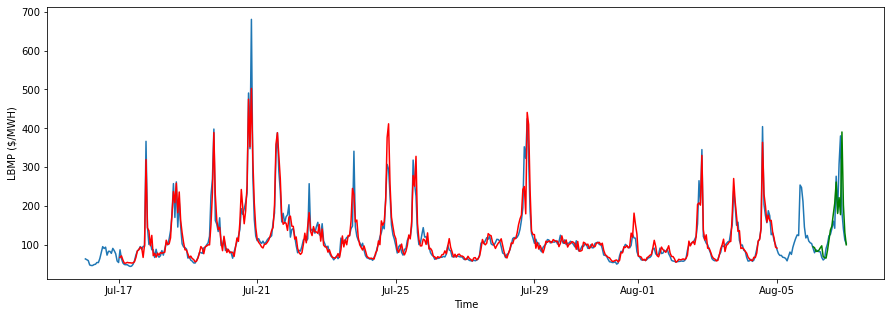

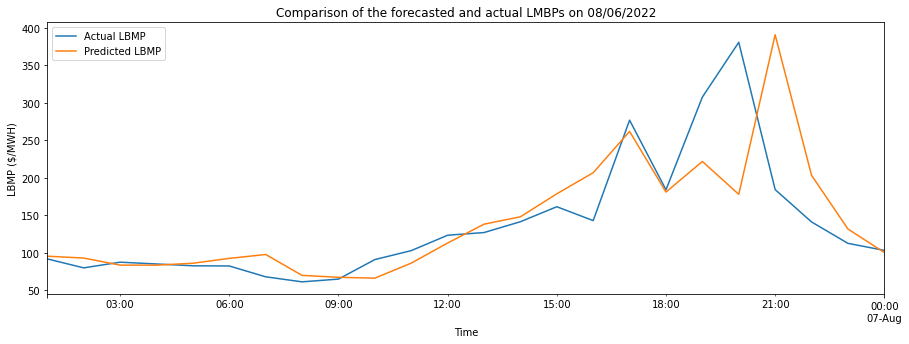

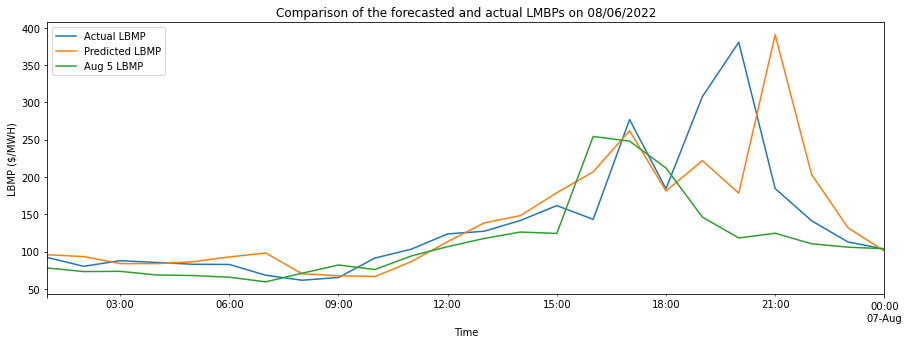

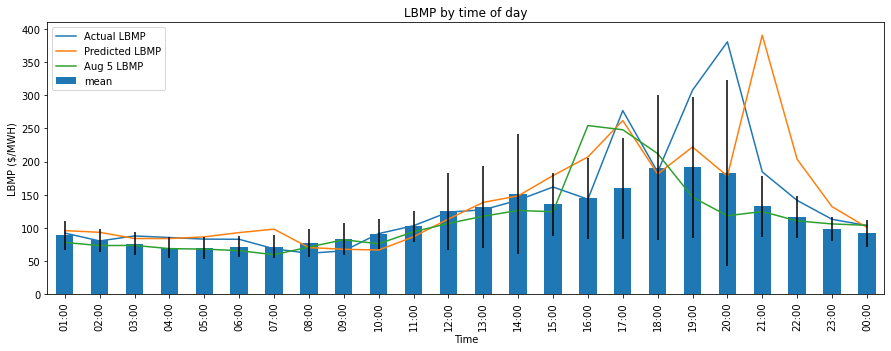

In [8]:
main_forecast_alg(test_date='2022-08-06',num_train_days=21,delta_t=60,lookback = 24)

Epoch 0: train RMSE 133.2581, test RMSE 131.2260
Epoch 100: train RMSE 52.0656, test RMSE 44.1833
Epoch 200: train RMSE 35.4426, test RMSE 41.6111
Epoch 300: train RMSE 29.6457, test RMSE 48.3178
Epoch 400: train RMSE 23.1642, test RMSE 46.8681
Epoch 500: train RMSE 26.1526, test RMSE 49.7494
Epoch 600: train RMSE 18.2392, test RMSE 47.6301
Epoch 700: train RMSE 16.5430, test RMSE 48.9340
Epoch 800: train RMSE 15.6053, test RMSE 48.2853
Epoch 900: train RMSE 14.5848, test RMSE 50.2650


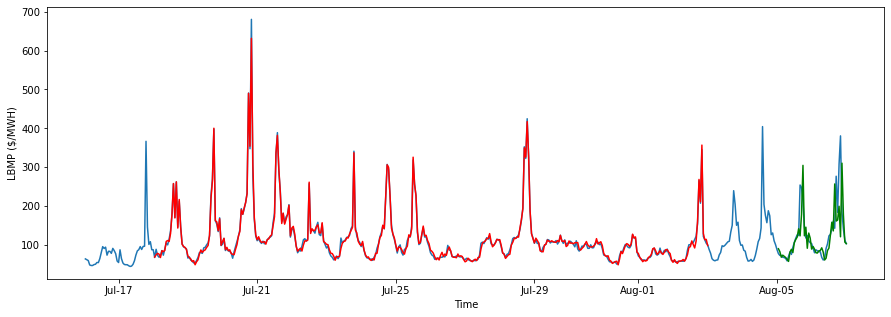

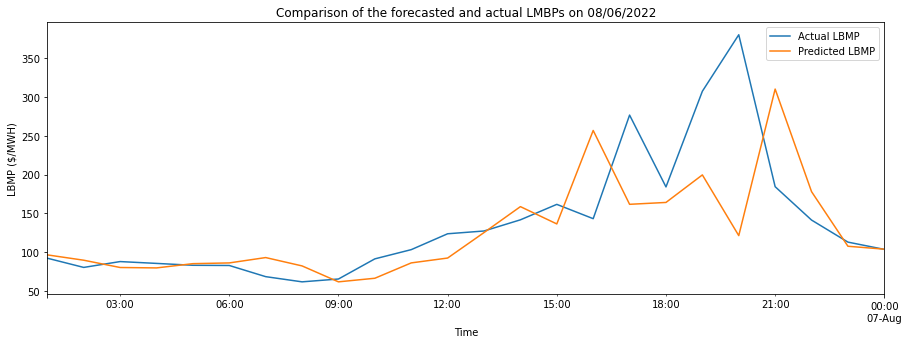

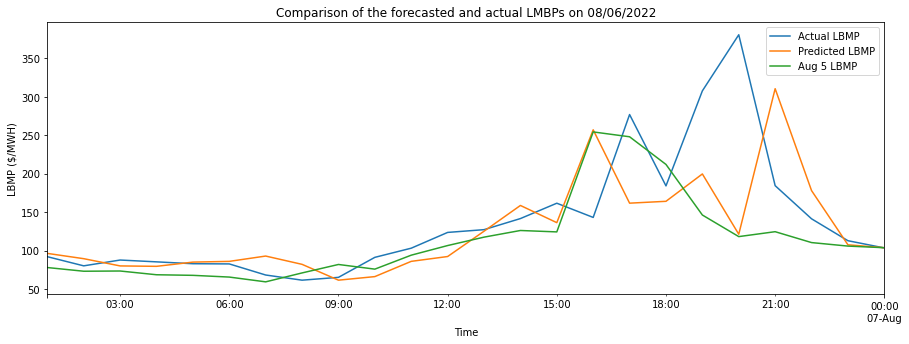

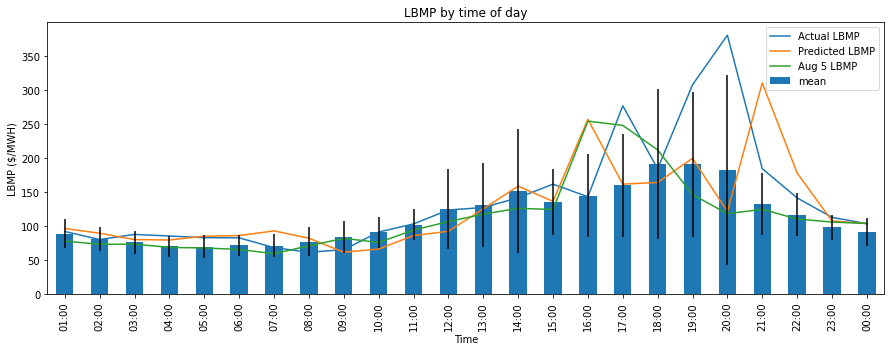

In [9]:
main_forecast_alg(test_date='2022-08-06',num_train_days=21,delta_t=60,lookback = 48)

## Model parameters
- For our project, we employed the Long Short-Term Memory (LSTM) method to forecast the hourly LBMPs on August 6th, 2022, using 21 days of training data. The lookback parameter is a critical parameter that governs the amount of data that the model can use to make a prediction. We tried two lookback values, 24 and 48 hours, and found that the 24-hour lookback produced a better prediction in terms of RMSE. We trained the model for 1000 epochs.

- In practice, it would be more reasonable to split the dataset into three partitions: training, validation, and test sets, and then tune the model parameters based on its performance on the validation set. Finally, we would apply the model to the test set. However, due to time constraints, we only used a train/test partitioning approach for this project.

## Insights

- Based on the predicted LBMPs, we see that overall they follow the same pattern as the actual LBMPs with the major deviation at the peak time. Taking a closer look at LBMPs the day before (August 5th) and average LBMPs, we see that August 5th LBMPs contributes these deviations.

- Based on the predicted LBMPs, we found that they generally follow the same pattern as the actual LBMPs, with significant deviation occurring at the peak time. Upon further analysis of the LBMPs on August 5th and the average LBMPs, we discovered that the deviation was caused by the LBMPs on August 5th.

## Suggestions

Here are some suggestions and items to improve the prediction model:

Data preprocessing: Ensure that the data is clean and preprocessed correctly, including addressing missing or erroneous data points, normalization, and scaling. This could improve the accuracy of the model's predictions.

Model selection: Consider experimenting with different machine learning models in addition to LSTM, such as ARIMA, to see if they offer better performance.

Hyperparameter tuning: Optimize the model's hyperparameters, such as the number of layers, learning rate, and number of epochs, to improve its accuracy and reduce overfitting.

Use of validation set: Implement the use of a validation set to fine-tune the model and prevent overfitting.

Incorporate external variables: Consider including other variables that may influence LBMPs, such as weather conditions,oil price, energy supply and demand, to improve the model's predictive power.



Model evaluation: Use additional metrics beyond RMSE to evaluate the model's performance, such as MAE, R-squared, and visual inspection of predicted vs. actual values.

Feature engineering: Experiment with different features, such as lagged variables, moving averages, or Fourier transforms, to improve the model's ability to capture patterns in the data.

Interpretability: Consider using methods such as SHAP (SHapley Additive exPlanations) or LIME (Local Interpretable Model-agnostic Explanations) to improve the interpretability of the model's predictions, allowing stakeholders to better understand the factors driving the model's output.